Using python 3.9.6 kernel for this notebook

In [2]:
%pip install --upgrade numpy pandas statsmodels scipy pandas_datareader yfinance matplotlib pandas_ta

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import datetime as dt 
import yfinance as yf
#import pandas_ta as ta
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
sp_500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S&P_500_companies') [0]

Lets clean the above data a bit

In [4]:
sp_500['Symbol'] = sp_500['Symbol'].str.replace('.', '-')
symbol_list = sp_500['Symbol'].unique().tolist()

end_date  = '2025-05-10'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8) #going back 8 years

df = yf.download(tickers=symbol_list, start=start_date, end=end_date)

[*********************100%***********************]  502 of 503 completed

1 Failed download:
['WBD']: Timeout('Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
[*********************100%***********************]  502 of 503 completed

In [5]:
df

Price      Adj Close       Close                                      \
Ticker           WBD           A        AAPL        ABBV        ABNB   
Date                                                                   
2017-05-12       NaN   52.861511   36.360310   46.917583         NaN   
2017-05-15       NaN   53.369793   36.267136   47.350822         NaN   
2017-05-16       NaN   53.492165   36.213566   47.478664         NaN   
2017-05-17       NaN   52.494415   34.997665   46.427540         NaN   
2017-05-18       NaN   52.569710   35.531082   46.612186         NaN   
...              ...         ...         ...         ...         ...   
2025-05-05       NaN  108.370003  198.629532  196.070007  124.889999   
2025-05-06       NaN  105.239998  198.250015  187.149994  121.669998   
2025-05-07       NaN  107.519997  195.992981  188.089996  123.120003   
2025-05-08       NaN  108.699997  197.231369  185.580002  126.389999   
2025-05-09       NaN  106.930000  198.270004  184.600006  127.040001   

Price                                                                  ...  \
Ticker             ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                   ...   
2017-05-12   38.138569  30.172010  106.990799  136.839996   67.199364  ...   
2017-05-15   38.207966  30.327324  108.131805  137.600006   68.549660  ...   
2017-05-16   37.904335  30.206877  108.919052  138.029999   69.267525  ...   
2017-05-17   37.375107  29.931116  106.530838  134.330002   67.019859  ...   
2017-05-18   37.288338  30.194197  106.495483  134.539993   68.780403  ...   
...                ...        ...         ...         ...         ...  ...   
2025-05-05  132.600006  92.580002  307.709991  381.059998  196.823868  ...   
2025-05-06  133.059998  93.000000  303.799988  382.980011  194.713486  ...   
2025-05-07  133.949997  92.690002  306.089996  384.970001  198.954163  ...   
2025-05-08  134.000000  94.559998  308.880005  383.989990  201.860931  ...   
2025-05-09  133.240005  94.540001  307.899994  383.279999  206.569489  ...   

Price        Volume                                                         \
Ticker          WTW       WY     WYNN      XEL       XOM      XYL      YUM   
Date                                                                         
2017-05-12   937700  1743000  2374900  3460100   7480200   982900  1482300   
2017-05-15  1020100  1646600  1396300  2721400  10881500  1637800  1619900   
2017-05-16   789800  1786800  2408100  2601800   9574200  1109000  2440300   
2017-05-17  1340000  2637200  2716000  2096600  11151100  1073400  1798500   
2017-05-18  1493600  2639100  1651800  2498700   9905800   968700  3139300   
...             ...      ...      ...      ...       ...      ...      ...   
2025-05-05   570300  2814200  2105200  5645600  19624000  1411000  2308500   
2025-05-06   728600  5555900  3011500  2765400  16303400  1606800  2097000   
2025-05-07   816100  4117600  3846700  4552300  12332200  1664200  1416000   
2025-05-08   706800  3812400  3041300  3160000  19196500   986100  1410900   
2025-05-09   396300  4948200  3216400  2479300  10992100   664800  1068500   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2017-05-12  2089355  229800  3425100  
2017-05-15  2595703  357500  2319400  
2017-05-16  3984349  290700  1816300  
2017-05-17  1820834  440200  2397600  
2017-05-18  1121876  293800  1583700  
...             ...     ...      ...  
2025-05-05  7058300  426400  3888600  
2025-05-06  4203100  521600  4124400  
2025-05-07  2662400  822600  4453800  
2025-05-08  2886100  711000  5580100  
2025-05-09  3438600  700800  4243100  

[2010 rows x 2516 columns]

In [6]:
df = df.stack()

In [7]:
df.index.name = 'date'
df.columns = df.columns.str.lower()
df

Price              adj close       close        high         low        open  \
Date       Ticker                                                              
2017-05-12 A             NaN   52.861511   53.087417   52.673257   52.861511   
           AAPL          NaN   36.360310   36.434845   36.027218   36.034206   
           ABBV          NaN   46.917583   47.009916   46.313892   46.356504   
           ABT           NaN   38.138569   38.320759   38.060487   38.086517   
           ACGL          NaN   30.172010   30.270269   30.086429   30.108618   
...                      ...         ...         ...         ...         ...   
2025-05-09 XYL           NaN  122.458916  123.605256  122.229652  123.166655   
           YUM           NaN  146.411804  148.242819  145.774929  147.536278   
           ZBH           NaN   95.209999   96.580002   94.360001   95.080002   
           ZBRA          NaN  266.709991  268.579987  264.640015  267.670013   
           ZTS           NaN  159.270004  162.440002  159.080002  161.410004   

Price                   volume  
Date       Ticker               
2017-05-12 A         1578300.0  
           AAPL    130108000.0  
           ABBV      6093500.0  
           ABT       5775800.0  
           ACGL       593100.0  
...                        ...  
2025-05-09 XYL        664800.0  
           YUM       1068500.0  
           ZBH       3438600.0  
           ZBRA       700800.0  
           ZTS       4243100.0  

[988324 rows x 6 columns]

Let's try out a fee features and indicators of the stocks that we have aggregated

Intraday colatility of a given asset - German-Klass Volatility

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [8]:
#lets make a new column and compute the formula from above
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2*np.log(2) - 1)*((np.log(df['close']) - np.log(df['open']))**2)

df

Price              adj close       close        high         low        open  \
Date       Ticker                                                              
2017-05-12 A             NaN   52.861511   53.087417   52.673257   52.861511   
           AAPL          NaN   36.360310   36.434845   36.027218   36.034206   
           ABBV          NaN   46.917583   47.009916   46.313892   46.356504   
           ABT           NaN   38.138569   38.320759   38.060487   38.086517   
           ACGL          NaN   30.172010   30.270269   30.086429   30.108618   
...                      ...         ...         ...         ...         ...   
2025-05-09 XYL           NaN  122.458916  123.605256  122.229652  123.166655   
           YUM           NaN  146.411804  148.242819  145.774929  147.536278   
           ZBH           NaN   95.209999   96.580002   94.360001   95.080002   
           ZBRA          NaN  266.709991  268.579987  264.640015  267.670013   
           ZTS           NaN  159.270004  162.440002  159.080002  161.410004   

Price                   volume  garman_klass_vol  
Date       Ticker                                 
2017-05-12 A         1578300.0          0.000031  
           AAPL    130108000.0          0.000032  
           ABBV      6093500.0          0.000055  
           ABT       5775800.0          0.000023  
           ACGL       593100.0          0.000017  
...                        ...               ...  
2025-05-09 XYL        664800.0          0.000050  
           YUM       1068500.0          0.000118  
           ZBH       3438600.0          0.000270  
           ZBRA       700800.0          0.000104  
           ZTS       4243100.0          0.000150  

[988324 rows x 7 columns]

In [9]:
#Now lets look at the relative strength index
import pandas_ta
#rsi is Relative Strength Index - a technical indicator used in stock trading to assess the speed and change of price movements, helping traders identify potential overbought or oversold conditions.
df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))


Lets check a specfic one, maybe APPLE (AAPL)

<Axes: xlabel='Date'>

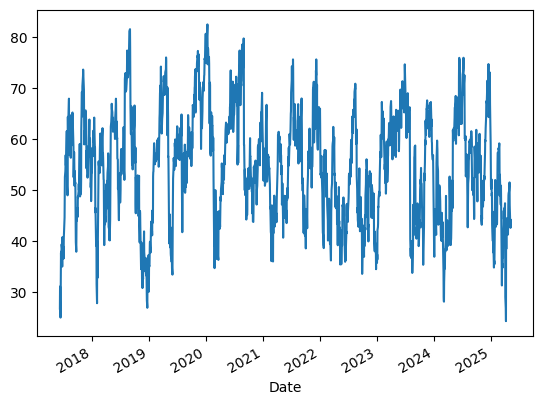

In [10]:
df.xs('AAPL', level=1)['rsi'].plot()

Now lets work with Bollinger Bands - these help us get a better sense of the volatility

In [11]:
pandas_ta.bbands(close=df.xs('AAPL', level=1)['close'], length=20)

#first column is the lower band, secon column is the middle band, and third column is upper band 

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
Date,,,,,
2017-05-12,NaN,NaN,NaN,NaN,NaN
2017-05-15,NaN,NaN,NaN,NaN,NaN
2017-05-16,NaN,NaN,NaN,NaN,NaN
2017-05-17,NaN,NaN,NaN,NaN,NaN
2017-05-18,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-05-05,179.609517,199.926330,220.243143,20.324299,0.468086
2025-05-06,182.325942,200.777712,219.229483,18.380297,0.431505
2025-05-07,188.701933,201.967651,215.233370,13.136479,0.274808


In [12]:
df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df


Price              adj close       close        high         low        open  \
Date       Ticker                                                              
2017-05-12 A             NaN   52.861511   53.087417   52.673257   52.861511   
           AAPL          NaN   36.360310   36.434845   36.027218   36.034206   
           ABBV          NaN   46.917583   47.009916   46.313892   46.356504   
           ABT           NaN   38.138569   38.320759   38.060487   38.086517   
           ACGL          NaN   30.172010   30.270269   30.086429   30.108618   
...                      ...         ...         ...         ...         ...   
2025-05-09 XYL           NaN  122.458916  123.605256  122.229652  123.166655   
           YUM           NaN  146.411804  148.242819  145.774929  147.536278   
           ZBH           NaN   95.209999   96.580002   94.360001   95.080002   
           ZBRA          NaN  266.709991  268.579987  264.640015  267.670013   
           ZTS           NaN  159.270004  162.440002  159.080002  161.410004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2017-05-12 A         1578300.0          0.000031        NaN       NaN   
           AAPL    130108000.0          0.000032        NaN       NaN   
           ABBV      6093500.0          0.000055        NaN       NaN   
           ABT       5775800.0          0.000023        NaN       NaN   
           ACGL       593100.0          0.000017        NaN       NaN   
...                        ...               ...        ...       ...   
2025-05-09 XYL        664800.0          0.000050  57.264323  4.665557   
           YUM       1068500.0          0.000118  48.007857  4.956436   
           ZBH       3438600.0          0.000270  39.772617  4.524654   
           ZBRA       700800.0          0.000104  52.322959  5.381005   
           ZTS       4243100.0          0.000150  52.741649  4.980900   

Price                bb_mid   bb_high  
Date       Ticker                      
2017-05-12 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2025-05-09 XYL     4.759171  4.852784  
           YUM     4.989254  5.022073  
           ZBH     4.600213  4.675772  
           ZBRA    5.494977  5.608949  
           ZTS     5.036342  5.091783  

[988324 rows x 11 columns]

Now lets work with the ATR. Average True Range (ATR) is a technical indicator that measures market volatility. It doesn't indicate the direction of price movement, but rather the degree of price fluctuation over a given period. Essentially, it helps traders understand how much a stock or asset typically moves, which is crucial for managing risk and making informed trading decisions. 


In [13]:
#lets make a function

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], 
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    
    #We should also normalize the data while the calculations are happening
    
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr) #if we dont put false, it will double the date column, we dont want that
#.apply() lets you run a custom function on each group or row/column, making it very flexible for group-wise calculations.
df


Price              adj close       close        high         low        open  \
Date       Ticker                                                              
2017-05-12 A             NaN   52.861511   53.087417   52.673257   52.861511   
           AAPL          NaN   36.360310   36.434845   36.027218   36.034206   
           ABBV          NaN   46.917583   47.009916   46.313892   46.356504   
           ABT           NaN   38.138569   38.320759   38.060487   38.086517   
           ACGL          NaN   30.172010   30.270269   30.086429   30.108618   
...                      ...         ...         ...         ...         ...   
2025-05-09 XYL           NaN  122.458916  123.605256  122.229652  123.166655   
           YUM           NaN  146.411804  148.242819  145.774929  147.536278   
           ZBH           NaN   95.209999   96.580002   94.360001   95.080002   
           ZBRA          NaN  266.709991  268.579987  264.640015  267.670013   
           ZTS           NaN  159.270004  162.440002  159.080002  161.410004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2017-05-12 A         1578300.0          0.000031        NaN       NaN   
           AAPL    130108000.0          0.000032        NaN       NaN   
           ABBV      6093500.0          0.000055        NaN       NaN   
           ABT       5775800.0          0.000023        NaN       NaN   
           ACGL       593100.0          0.000017        NaN       NaN   
...                        ...               ...        ...       ...   
2025-05-09 XYL        664800.0          0.000050  57.264323  4.665557   
           YUM       1068500.0          0.000118  48.007857  4.956436   
           ZBH       3438600.0          0.000270  39.772617  4.524654   
           ZBRA       700800.0          0.000104  52.322959  5.381005   
           ZTS       4243100.0          0.000150  52.741649  4.980900   

Price                bb_mid   bb_high       atr  
Date       Ticker                                
2017-05-12 A            NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2025-05-09 XYL     4.759171  4.852784  1.472153  
           YUM     4.989254  5.022073  2.111445  
           ZBH     4.600213  4.675772  0.464572  
           ZBRA    5.494977  5.608949  0.598954  
           ZTS     5.036342  5.091783  1.426151  

[988324 rows x 12 columns]

The next indicator we will calculate is the MACD indicator. Moving Average Convergence Divergence indicator is a popular technical analysis tool used to identify potential buy and sell signals in financial markets. Traders use MACD to understand price trends, momentum, and potential reversals, making it a versatile tool for both beginners and experienced traders 

In [14]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

df

Price              adj close       close        high         low        open  \
Date       Ticker                                                              
2017-05-12 A             NaN   52.861511   53.087417   52.673257   52.861511   
           AAPL          NaN   36.360310   36.434845   36.027218   36.034206   
           ABBV          NaN   46.917583   47.009916   46.313892   46.356504   
           ABT           NaN   38.138569   38.320759   38.060487   38.086517   
           ACGL          NaN   30.172010   30.270269   30.086429   30.108618   
...                      ...         ...         ...         ...         ...   
2025-05-09 XYL           NaN  122.458916  123.605256  122.229652  123.166655   
           YUM           NaN  146.411804  148.242819  145.774929  147.536278   
           ZBH           NaN   95.209999   96.580002   94.360001   95.080002   
           ZBRA          NaN  266.709991  268.579987  264.640015  267.670013   
           ZTS           NaN  159.270004  162.440002  159.080002  161.410004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2017-05-12 A         1578300.0          0.000031        NaN       NaN   
           AAPL    130108000.0          0.000032        NaN       NaN   
           ABBV      6093500.0          0.000055        NaN       NaN   
           ABT       5775800.0          0.000023        NaN       NaN   
           ACGL       593100.0          0.000017        NaN       NaN   
...                        ...               ...        ...       ...   
2025-05-09 XYL        664800.0          0.000050  57.264323  4.665557   
           YUM       1068500.0          0.000118  48.007857  4.956436   
           ZBH       3438600.0          0.000270  39.772617  4.524654   
           ZBRA       700800.0          0.000104  52.322959  5.381005   
           ZTS       4243100.0          0.000150  52.741649  4.980900   

Price                bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2017-05-12 A            NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2025-05-09 XYL     4.759171  4.852784  1.472153  0.952850  
           YUM     4.989254  5.022073  2.111445 -0.495916  
           ZBH     4.600213  4.675772  0.464572 -1.196245  
           ZBRA    5.494977  5.608949  0.598954 -0.040843  
           ZTS     5.036342  5.091783  1.426151  0.061950  

[988324 rows x 13 columns]

And for the last indicator, the dollar volume - it represents the total monetary value of shares traded in a specific stock over a defined period, usually a trading day. It's calculated by multiplying the trading volume (number of shares traded) by the stock's price. Essentially, it shows how much money is flowing into or out of a particular stock. 


In [15]:
df['dollar_volume'] = (df['close'] * df['volume'] / 1e6)

df

Price              adj close       close        high         low        open  \
Date       Ticker                                                              
2017-05-12 A             NaN   52.861511   53.087417   52.673257   52.861511   
           AAPL          NaN   36.360310   36.434845   36.027218   36.034206   
           ABBV          NaN   46.917583   47.009916   46.313892   46.356504   
           ABT           NaN   38.138569   38.320759   38.060487   38.086517   
           ACGL          NaN   30.172010   30.270269   30.086429   30.108618   
...                      ...         ...         ...         ...         ...   
2025-05-09 XYL           NaN  122.458916  123.605256  122.229652  123.166655   
           YUM           NaN  146.411804  148.242819  145.774929  147.536278   
           ZBH           NaN   95.209999   96.580002   94.360001   95.080002   
           ZBRA          NaN  266.709991  268.579987  264.640015  267.670013   
           ZTS           NaN  159.270004  162.440002  159.080002  161.410004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2017-05-12 A         1578300.0          0.000031        NaN       NaN   
           AAPL    130108000.0          0.000032        NaN       NaN   
           ABBV      6093500.0          0.000055        NaN       NaN   
           ABT       5775800.0          0.000023        NaN       NaN   
           ACGL       593100.0          0.000017        NaN       NaN   
...                        ...               ...        ...       ...   
2025-05-09 XYL        664800.0          0.000050  57.264323  4.665557   
           YUM       1068500.0          0.000118  48.007857  4.956436   
           ZBH       3438600.0          0.000270  39.772617  4.524654   
           ZBRA       700800.0          0.000104  52.322959  5.381005   
           ZTS       4243100.0          0.000150  52.741649  4.980900   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
Date       Ticker                                                         
2017-05-12 A            NaN       NaN       NaN       NaN      83.431323  
           AAPL         NaN       NaN       NaN       NaN    4730.767162  
           ABBV         NaN       NaN       NaN       NaN     285.892295  
           ABT          NaN       NaN       NaN       NaN     220.280746  
           ACGL         NaN       NaN       NaN       NaN      17.895019  
...                     ...       ...       ...       ...            ...  
2025-05-09 XYL     4.759171  4.852784  1.472153  0.952850      81.410687  
           YUM     4.989254  5.022073  2.111445 -0.495916     156.441013  
           ZBH     4.600213  4.675772  0.464572 -1.196245     327.389103  
           ZBRA    5.494977  5.608949  0.598954 -0.040843     186.910362  
           ZTS     5.036342  5.091783  1.426151  0.061950     675.798555  

[988324 rows x 14 columns]

#### Now for some fun !!!

Let us proceed to aggregate on a monthly level the data an filter the __top 150__ most liquid stocks in each month. 

So lets aggregate all the indicators that we have and take the last value for a month. and for the dollar volume, we can take the average dollar volume for the whole month for each stock

In [18]:
df.unstack('Ticker')['dollar_volume']
#so we will be able to see the dollar volume for each day for each stock now

Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,ABNB,EXE,COIN,CEG,GEHC,KVUE,VLTO,GEV,SOLV,SW
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-12,83.431323,4730.767162,285.892295,220.280746,17.895019,252.744364,222.583938,132.738903,51.244993,159.835485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-15,78.571009,3773.189269,403.803079,161.371344,18.223689,191.631186,441.723540,276.543037,100.867305,278.327010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-16,55.236009,2904.110698,299.756548,271.368506,24.304453,237.508885,313.576551,208.626858,74.546874,182.879823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-17,96.573976,7107.003912,592.944682,223.850727,27.270240,242.666596,478.013312,240.735335,81.063281,229.169854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-18,101.722388,4770.857888,279.719731,194.835293,36.531959,209.668308,559.511470,345.731574,78.175418,181.613185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05,150.146639,13709.112345,1004.172543,762.715235,88.367612,1091.939676,798.549331,398.115637,148.987609,372.858870,...,844.431242,355.902264,1018.674749,773.000175,411.176817,545.559111,120.770352,921.286604,61.886627,110.321887
2025-05-06,206.333540,10153.671907,1757.712743,837.013915,129.037500,826.153687,1137.488931,493.696043,235.168978,303.874288,...,636.248921,300.386118,919.988211,1967.611216,380.896745,352.412038,110.360129,899.838546,74.956604,129.060548
2025-05-07,230.490617,13432.712138,1085.599032,659.690340,113.452563,810.434483,828.840413,590.038360,218.875927,611.273055,...,421.513641,274.463353,948.539580,1383.111155,365.055688,832.291153,144.183040,1012.428041,57.343042,132.732000


Same thing but lets just do it monthly instead of daily

In [19]:
df.unstack('Ticker')['dollar_volume'].resample('M').mean()


Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,ABNB,EXE,COIN,CEG,GEHC,KVUE,VLTO,GEV,SOLV,SW
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-31,146.243740,3713.692751,287.210708,238.338548,31.972584,208.116385,347.696520,299.530327,97.713224,188.566661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-30,109.548804,4268.541371,298.847282,302.877910,69.558512,283.467956,487.187568,341.768316,94.412739,257.901291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31,92.018443,2915.393034,258.186401,247.002306,42.369787,188.725550,258.590292,152.844779,98.297958,493.617232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-31,109.160828,4261.835075,221.157783,190.536160,38.328294,172.058037,223.901787,156.832447,102.322708,572.968943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-30,86.566970,5006.405034,590.508822,284.934810,64.275965,304.429547,416.120707,177.799140,98.073788,275.627853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,256.430487,13974.256257,1078.091577,868.919526,182.337957,992.314520,1717.593976,708.371370,153.154829,509.535740,...,534.273254,306.852484,2323.920348,1787.494312,229.851651,243.491801,133.027391,1621.638763,72.943240,154.853117
2025-02-28,238.402096,10806.283379,1154.079570,764.692697,174.178041,1045.438086,1306.045270,983.636537,208.790058,470.596596,...,917.107108,304.562968,2510.981574,1096.567324,277.144398,383.584650,166.188475,1227.361069,80.707978,205.464693
2025-03-31,259.507155,11787.984455,1468.864909,995.526326,159.570252,1353.909013,1812.447386,761.150301,291.644865,633.886923,...,697.098575,700.458942,1839.538686,963.713191,297.315706,361.464603,140.553168,1355.902522,94.189163,197.157215


and same thing again but lets just stack it back into a multindex

In [21]:
df.unstack('Ticker')['dollar_volume'].resample('M').mean().stack('Ticker').to_frame('dollar_volume')


dollar_volume
Date       Ticker               
2017-05-31 A          146.243740
           AAPL      3713.692751
           ABBV       287.210708
           ABT        238.338548
           ACGL        31.972584
...                          ...
2025-05-31 KVUE       543.443025
           VLTO       124.946027
           GEV       1110.381896
           SOLV        75.725056
           SW         128.931136

[47707 rows x 1 columns]

We can follow the same logic and steps for the indicators, but we need to select the exact columns. So lets create a list of columns called last_cols. We would then apply the above operations and steps to last_cols

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high'
                                                          , 'low', 'close']]

last_cols
#the dollar volume will only be used to filter out the most liquid stocks, it will not be featured in our model, along with volume. open, high, low, close

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

### For the next cell

df.unstack()

Converts the inner level of the MultiIndex (likely 'Ticker') from the index into columns, so you get a DataFrame where each column is a stock/indicator and each row is a date.
[last_cols]

Selects only the columns in last_cols (these are your technical indicators, not price/volume columns).
.resample('M')

Resamples the DataFrame to a monthly frequency based on the date index.
.last()

For each month, takes the last available value for each indicator and stock.


In [30]:
df.unstack()[last_cols].resample('M').last().stack('Ticker')

Price              adj close  garman_klass_vol        rsi    bb_low    bb_mid  \
Date       Ticker                                                               
2017-05-31 A             NaN          0.000171        NaN       NaN       NaN   
           AAPL          NaN          0.000044        NaN       NaN       NaN   
           ABBV          NaN          0.000069        NaN       NaN       NaN   
           ABT           NaN          0.000039        NaN       NaN       NaN   
           ACGL          NaN          0.000222        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2025-05-31 XYL           NaN          0.000050  57.264323  4.665557  4.759171   
           YUM           NaN          0.000118  48.007857  4.956436  4.989254   
           ZBH           NaN          0.000270  39.772617  4.524654  4.600213   
           ZBRA          NaN          0.000104  52.322959  5.381005  5.494977   
           ZTS           NaN          0.000150  52.741649  4.980900  5.036342   

Price               bb_high       atr      macd  
Date       Ticker                                
2017-05-31 A            NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2025-05-31 XYL     4.852784  1.472153  0.952850  
           YUM     5.022073  2.111445 -0.495916  
           ZBH     4.675772  0.464572 -1.196245  
           ZBRA    5.608949  0.598954 -0.040843  
           ZTS     5.091783  1.426151  0.061950  

[47707 rows x 8 columns]

lets just concatenate the dollar volume and the others

In [42]:
data = pd.concat([df.unstack('Ticker')['dollar_volume'].resample('M').mean().stack('Ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('Ticker')], axis=1)
data

dollar_volume  adj close  garman_klass_vol        rsi  \
Date       Ticker                                                          
2017-05-31 A          146.243740        NaN          0.000171        NaN   
           AAPL      3713.692751        NaN          0.000044        NaN   
           ABBV       287.210708        NaN          0.000069        NaN   
           ABT        238.338548        NaN          0.000039        NaN   
           ACGL        31.972584        NaN          0.000222        NaN   
...                          ...        ...               ...        ...   
2025-05-31 KVUE       543.443025        NaN          0.000104  59.706359   
           VLTO       124.946027        NaN          0.000096  55.770095   
           GEV       1110.381896        NaN          0.000503  62.947600   
           SOLV        75.725056        NaN          0.001415  52.794479   
           SW         128.931136        NaN          0.000159  47.005935   

                     bb_low    bb_mid   bb_high       atr      macd  
Date       Ticker                                                    
2017-05-31 A            NaN       NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...       ...  
2025-05-31 KVUE    3.130836  3.179450  3.228063  2.308338  0.846981  
           VLTO    4.474921  4.538782  4.602644  1.573761  0.346063  
           GEV     5.708807  5.888226  6.067645  0.978859  1.729556  
           SOLV    4.172588  4.209450  4.246312  0.951431 -0.591663  
           SW      3.702634  3.744381  3.786128  0.381892 -0.456021  

[47707 rows x 9 columns]

In [43]:
37.38

37.38